# Practical work 1: representation, measurements and sparsity

The goal of this notebook is to get familiar with some concepts presented during the first 2 course sessions and to get some intuition for the sequel.


## I. Approximations

In this section, signals or images are represented in various bases. We are particularly interested in basis in which a few coefficients carry out the main information of the signal (i.e. in which the signal will be nearly sparse).

In order to measure the difference between the image and its compressed version, one can use the Signal-to-noise ration (SNR), defined as follows:
$$ \text{SNR} = -20 \log_{10} \frac{\| f- f_{[K]} \|}{\| f\|},
$$
where $f_{[K]}$ is a (sparse) approximation of $f$. The higer the SNR, the better the quality of the approximation.


### 1) Preliminaries

We need to load some packages to make accessible the usual Python routines. 

In [1]:
#from __future__ import division  # For Python 2 only

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt
from scipy.io import loadmat

from nt_toolbox.general import *
from nt_toolbox.signal import *
from nt_toolbox.optim import *
from nt_toolbox.perform_wavelet_transf import *
from nt_toolbox.compute_wavelet_filter import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2


First, we load an image in the variable $\texttt{f}$. An image with $n$ pixels is stored on a computer as a matrix of size $n_0\times n_0$ with $n=n_0 \times n_0$.

In [2]:
n0 = 512
f = rescale(load_image("nt_toolbox/data/lena.png", n0))
f.shape # to check the dimensions of f  

(512, 512)

To display the image, proceed as follows.

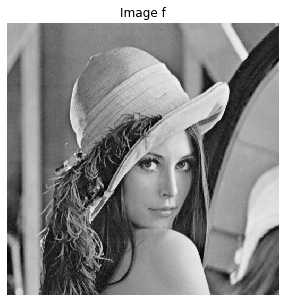

In [3]:
plt.figure(figsize = (5,5))
imageplot(f, 'Image f')

### 2) Fourier transform
In 2D, the Fourier orthonormal basis is defined as
$$ \psi_m(k) = \frac{1}{\sqrt{n}}e^{\frac{2i\pi}{n_0} \left\langle m , k \right\rangle } $$
where $0 \leq k_1,k_2 < n_0$ are position indexes,
and $0 \leq m_1,m_2 < n_0$ are frequency indexes.


The Fourier transform $\hat f$ is the projection of the image on this Fourier
basis

$$ \hat f(m) = \left\langle f , \psi_m \right\rangle. $$


The Fourier transform is computed in $ O(n \log(n)) $ operation using the FFT algorithm
(Fast Fourier Transform).
Note the normalization by $\sqrt{n}=n_0$ to make the transform orthonormal.

In [4]:
F = pyl.fft2(f)/n0

You can check that this is an isometry: it preserves the signal energy in the transformed domain.

In [5]:
from pylab import linalg

print("Energy of Image:   %f" %linalg.norm(f))
print("Energy of Fourier: %f" %linalg.norm(F))

Energy of Image:   279.584717
Energy of Fourier: 279.584768


Compute the logarithm of the Fourier magnitude $ \log\left(\left|\hat f(m)\right| +
\epsilon\right) $, for some small $\epsilon$.

In [6]:
L = pyl.fftshift(np.log(abs(F) + 1e-1))

Display. Note that we use the function fftshift to put the 0 low frequency in the
middle.

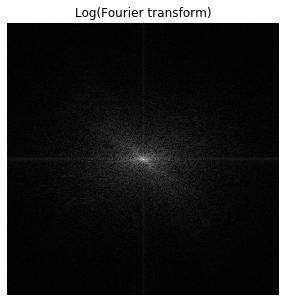

In [7]:
plt.figure(figsize = (5,5))
imageplot(L, 'Log(Fourier transform)')

### Linear Fourier Approximation
----------------------------
An approximation is obtained by retaining a certain set of index $I_M$

$$ f_M = \sum_{ m \in I_M } \langle {f} , {\psi_m} \rangle \psi_m. $$


Linear approximation is obtained by retaining a *fixed* set $I_M$
of $M = |I_M|$ coefficients. The important point is that $I_M$
does not depend on the image $f$ to be approximated.


For the Fourier transform, a low pass linear approximation
is obtained by keeping only the frequencies within a square.

$$ I_M = \{m=(m_1,m_2), \quad { -q/2 \leq m_1,m_2 < q/2 } \} $$
where $ q = \sqrt{M} $.


This can be achieved by computing the Fourier transform,
setting to zero the $N-M$ coefficients outside the square $I_M$
and then inverting the Fourier transform.


Number $M$ of kept coefficients.

In [8]:
M = n0**2//64

__Exercise 1__ 


1.  Perform the linear Fourier approximation with $M$ coefficients.
+  Store the result in the variable $f_M$. 
+ Compute the SNR of the approximated image using the function $\texttt{snr}$.
+ Display the approximated image.


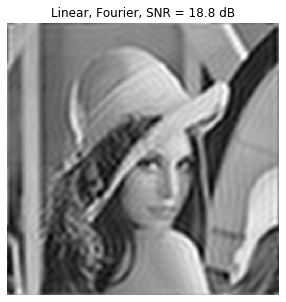

In [9]:
q = int(np.sqrt(M))
F = pyl.fftshift(pyl.fft2(f))

mask = np.zeros([n0,n0])
mask[n0//2 - q//2:n0//2 + q//2, n0//2 - q//2:n0//2 + q//2] = 1
F_zeros = F*mask #np.multiply(F,mask)

fM = np.real(pyl.ifft2(pyl.fftshift(F_zeros)))
plt.figure(figsize = (5,5))
imageplot(clamp(fM), "Linear, Fourier, SNR = %.1f dB" %snr(f, fM))

### Non-linear Fourier Approximation
--------------------------------
Non-linear approximation is obtained by keeping the $M$ largest
coefficients. This is equivalently computed using a thresholding of the
coefficients
$$ I_M = \left\{ m, \quad  \left| \langle f , \psi_m \rangle \right| >T \right\}. $$


We set a threshold $T>0$, and perform hard-thresholding on the Fourier coefficients.

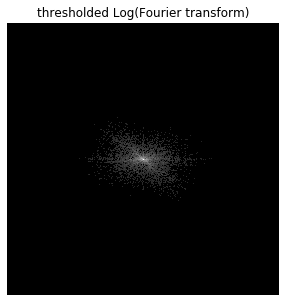

In [10]:
T = .2
F = pyl.fft2(f)/n0
FT = np.multiply(F,(abs(F) > T))

#display the log of thresholded Fourier coefficients
L = pyl.fftshift(np.log(abs(FT) + 1e-1))
plt.figure(figsize = (5,5))
imageplot(L, 'thresholded Log(Fourier transform)')

Once the hard-thresholding performed, one can go back in the initial domain, and see the corresponding non-linear approximation of the initial image.

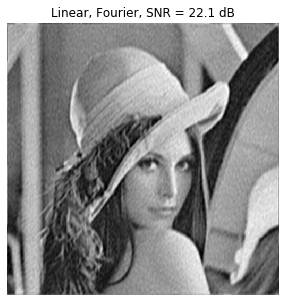

In [11]:
fM = np.real(pyl.ifft2(FT)*n0)

#display
plt.figure(figsize = (5,5))
imageplot(clamp(fM), "Linear, Fourier, SNR = %.1f dB" %snr(f, fM))

For a given $T$, one can compute the proportion of coefficients kept in the non-linear approximation.

In [12]:
m = np.sum(FT != 0)
print(M)
print('M/N = 1/%d'  %(n0**2/m))

4096
M/N = 1/30


__Exercise 2__ 


1.  Perform the non-linear Fourier approximation with $M$ coefficients: it means you have to find the right threshold $T$ in order to keep exactly $M$ coefficients.
+  Store the result in the variable $f_M$. 
+ Compute the SNR of the approximated image using the function $\texttt{snr}$.
+ Display the approximated image.
+ Compare with the linear approximation.

168.00450734802482


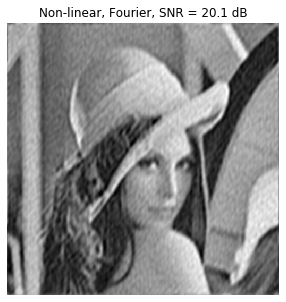

In [13]:
F = pyl.fft2(f)
a = np.sort(np.ravel(abs(F)))[::-1] #sort a 1D copy of F in descending order
T = a[M]
print(T)
FT = np.multiply(F,(abs(F) > T))
fM = np.real(pyl.ifft2(FT))
plt.figure(figsize = (5,5))
imageplot(clamp(fM), "Non-linear, Fourier, SNR = %.1f dB" %snr(f, fM))

## 3) Wavelets

A wavelet basis $ \mathcal{B} = \{ \psi_m \}_m $
is obtained over the continuous domain by translating and
dilating three mother wavelet functions $ \{\psi^V,\psi^H,\psi^D\} $
 (V,H,D to catch respectively Vertical, Horizontal and Diagonal details).

Each wavelet atom is defined as
$$ \psi_m(x) = \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k\left( \frac{x-2^j n}{2^j} \right) $$

The scale (size of the support) is $2^j$ and the position is
$2^j(n_1,n_2)$. The index is $ m=(k,j,n) $ for $\{ j \leq 0 \}$.


The wavelet transform computes all the inner products
$ \{ \langle f , \psi_{j,n}^k \rangle \}_{k,j,n} $.


Set the minimum scale for the transform to be 0.

In [14]:
Jmin = 0

Perform the wavelet transform,  $f_w$ stores all the wavelet coefficients.

In [15]:
h = compute_wavelet_filter("Daubechies",10)
fw = perform_wavortho_transf(f, Jmin, + 1, h)

Display.

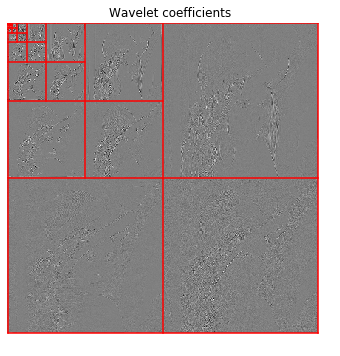

In [16]:
plt.figure(figsize=(6,6))

plot_wavelet(fw)
plt.title('Wavelet coefficients')

plt.show()

__Exercise 3__ 


1.  Perform the linear Wavelet approximation with $M$ coefficients.
+  Store the result in the variable $f_M$. 
+ Compute the SNR of the approximated image using the function $\texttt{snr}$.
+ Display the approximated image.

64


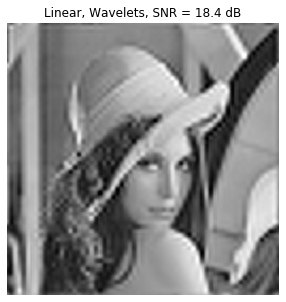

In [17]:
q = int(np.sqrt(M))
print(q)
fw = perform_wavortho_transf(f, Jmin, + 1, h)
fw1 = np.zeros([n0, n0])
fw1[:q, :q] = fw[:q, :q]
fM = perform_wavortho_transf(fw1, Jmin, -1,h)
plt.figure(figsize=(5,5))
imageplot(clamp(fM),  "Linear, Wavelets, SNR = %.1f dB" %snr(f, fM))

To perform a non-linear approximation using wavelet representation, we again use hard thresholding.

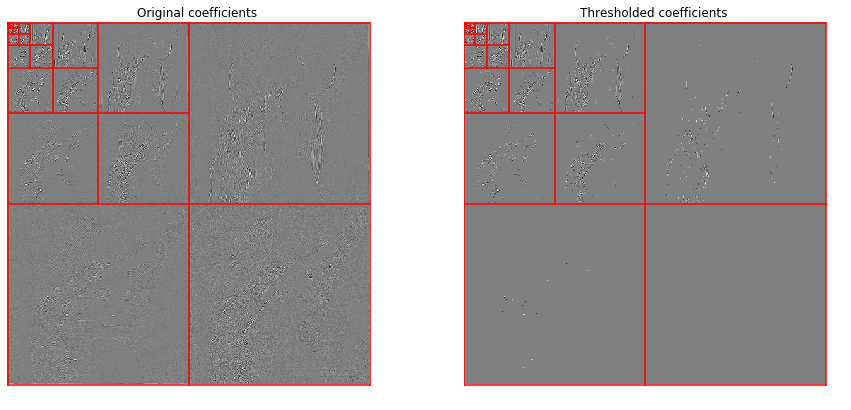

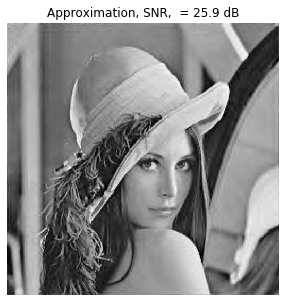

In [18]:
# Threshold
T = .15

# Hard-thresholding
fwT = np.multiply(fw,(abs(fw) > T))

# Display
plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plot_wavelet(fw)
plt.title('Original coefficients')

plt.subplot(1, 2, 2)
plot_wavelet(fwT)
plt.title('Thresholded coefficients')

plt.show()

# Perform reconstruction
fM = perform_wavortho_transf(fwT, Jmin, -1,h)


# Display
plt.figure(figsize=(5,5))
imageplot(clamp(fM), "Approximation, SNR,  = %.1f dB" %snr(f, fM))

__Exercise 4__ 


1.  Perform the non-linear Wavelet approximation keeping the $M$ largest coefficients.
+  Store the result in the variable $f_M$. 
+ Compute the SNR of the approximated image using the function $\texttt{snr}$.
+ Display the approximated image.

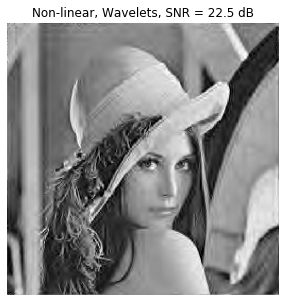

In [19]:
fw = perform_wavortho_transf(f, Jmin, + 1, h)
a = np.sort(np.ravel(abs(fw)))[::-1] #sort a 1D copy of fw in descending order
T = a[M]
fw1 = np.multiply(fw,(abs(fw) > T))
fM = perform_wavortho_transf(fw1, Jmin, -1,h)
plt.figure(figsize=(5,5))
imageplot(clamp(fM), "Non-linear, Wavelets, SNR = %.1f dB" %snr(f, fM))

### Approximation error (Wavelets vs. Fourier)
----------------------------------------------

The best $M$-term approximation error is computed using the
conservation of energy as

$$ \epsilon[M]^2 = \|f-f_M\|_2^2 = \sum_{ \left| \langle f , \psi_m \rangle \right| \leq T} \left| \langle f , \psi_m \rangle  \right|^2.  $$


If one denotes by $ \{ c_R[k] \}_{k=0}^{N-1} $ the set of
coefficients magnitudes $ \left| \langle f , \psi_m \rangle  \right| $ ordered by *decaying*
magnitudes, then this error is easily computed as
$$ \epsilon[M]^2 = \sum_{k=M}^{N-1} c_R[k]^2
    = \|f\|^2 - \sum_{k=0}^{M-1} c_R[k]^2. $$
This means that $\epsilon^2$ is equal to
$\|f\|^2$ minus the discrete primitive of $ c_R^2 $.


__Exercise 5 (wavelets vs. Fourier)__

1. Compute and store the values of $\epsilon[M]^2$ in vector $err\_wav$, $err\_fft$ for wavelet and fourier non-linear approximation.
+ Display in log-scale the non-linear approximation
error $\epsilon[M]^2$ for  wavelets and fourier bases.
+ Compare the Fourier and wavelets approximations.


2621 13107


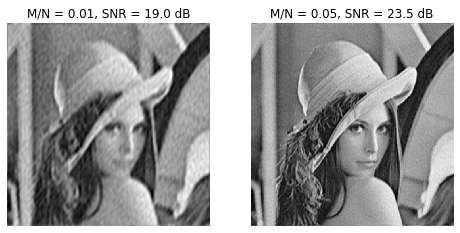

In [20]:
n = n0

# for Fourier

plt.figure(figsize = (8,8))
Mlist = [round(n**2/100), round(n**2/20)]
print(*Mlist)

for i in range(len(Mlist)):
    M = Mlist[i]
    #perform hard thresholding
    F = pyl.fft2(f)/n0
    a = np.sort(np.ravel(abs(F)))[::-1] #sort a 1D copy of F in descending order
    T = a[M]
    fFT = np.multiply(F,(abs(F) > T))
    fM = np.real(pyl.ifft2(fFT)*n0)
    imageplot(clamp(fM), "M/N = %.2f, SNR = %.1f dB" %(M/n**2,snr(f,fM)),[1, 2, i+1])



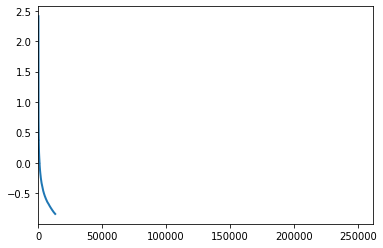

In [21]:
cR = np.sort(np.ravel(abs(fFT)))[::-1]
h = plt.plot(np.log10(cR), linewidth=2)
plt.xlim(0,n**2)

plt.show()

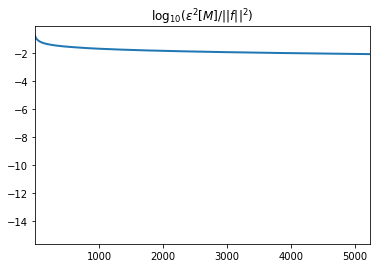

In [22]:
from pylab import linalg

F = pyl.fft2(f)/n0
cR = np.sort(np.ravel(abs(F)))[::-1]
err_fft = [max(e,1e-10) for e in linalg.norm(f)**2 - np.cumsum(cR**2)]
plt.plot(np.log10(err_fft/linalg.norm(F)**2),linewidth=2)
plt.title("$\log_{10}(\epsilon^2[M]/ ||f||^2)$")
plt.xlim(1,n**2/50)
#plt.ylim(-2.35,0)

plt.show()

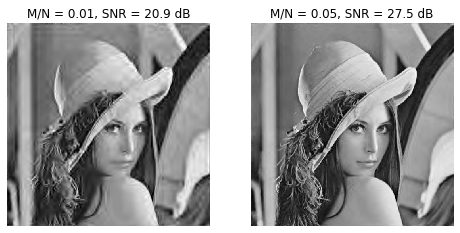

In [23]:
# for wavelets
plt.figure(figsize = (8,8))
Mlist = [round(n**2/100), round(n**2/20)]

from nt_toolbox.perform_wavelet_transf import *
from nt_toolbox.compute_wavelet_filter import *


#fw = perform_wavelet_transf(f, Jmin, + 1)

h = compute_wavelet_filter("Daubechies",10)
fW = perform_wavortho_transf(f, Jmin, + 1, h)

fw = perform_wavortho_transf(f, Jmin, + 1, h)
for i in range(len(Mlist)):
    M = Mlist[i]
    a = np.sort(np.ravel(abs(fw)))[::-1] #sort a 1D copy of F in descending order
    T = a[M]
    fWT = np.multiply(fw,(abs(fw) > T))
    fM = np.real(perform_wavortho_transf(fWT, Jmin, -1,h))
    imageplot(clamp(fM), "M/N = %.2f, SNR = %.1f dB" %(M/n**2,snr(f,fM)),[1, 2, i+1])

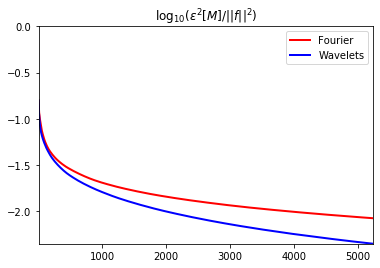

In [24]:
from pylab import linalg

cR = np.sort(np.ravel(abs(fw)))[::-1]
err_wav = [max(e,1e-10) for e in linalg.norm(f)**2 - np.cumsum(cR**2)]


# Comparison
plt.plot(np.log10(err_fft/linalg.norm(f)**2),linewidth=2, color = "red", label = "Fourier")
plt.plot(np.log10(err_wav/linalg.norm(f)**2),linewidth=2, color = "blue", label = "Wavelets")

plt.title("$\log_{10}(\epsilon^2[M]/ ||f||^2)$")
plt.xlim(1,n**2/50)
plt.ylim(-2.35,0)
plt.legend()

plt.show()

# II. A first regularization


In the setting of compressed sensing, we observe $m$ linear projections of an object $x \in \mathbb{R}^n$ where $m\ll n$. The data is contained in vector $y=Ax$ where $A$ is the sensing matrix.

We want to solve an under-determined linear system. To do so, one can choose to pick the solution with the minimimal energy in $\ell^2$-norm.

It can read as follows
$$ \min_{z \in  \mathbb{R}^n} \| z \|_2 \quad \text{s.t.} \quad y=Az.
$$




__ Exercice 6 __

1. Show that solving the above problem is equivalent to solving the following problem
$$ \min_{z \in  \mathbb{R}^n} \frac{1}{2}\| z \|_2^2 \quad \text{s.t.} \quad y=Az.
$$
+ Is there a solution to the above problem ? Is it unique ?
+ Using the Lagrangian, write optimality conditions. Deduce an optimum.
+ Now, we want to find the same optimum but using only Fermat's rule.
    1. Show that the problem can be rewritten as follows 
    $$ \min_{z \in  \mathbb{R}^n}\frac{1}{2} \| z \|_2^2 + \chi_C(z)
    $$
    where $\chi_C$ is the characteristic function of the (convex) set $C:=\{ x : y=Ax \}$.
    + Show that the subdifferential of a characteristic function of a convex set corresponds to the normal cone
    $$ \mathcal{N}_C(x) = \{ d , \langle d, y-x \rangle \leq 0 , \quad \forall y \in C \}
    $$ 
    + Show that the normal cone to the set $C:=\{ x : y=Ax \}$ is $\ker(A)^\perp = \text{ran} (A^*)$.
    + Write the Fermat's rule for the last optimization problem and deduce an optimum.
+ Implement the solution to the $\ell^2$-regularized problem that you have found in questions 3 and 4.

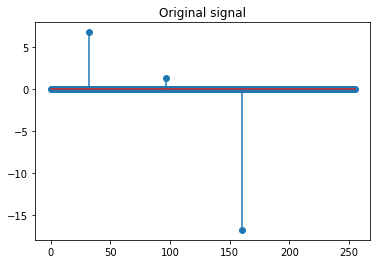

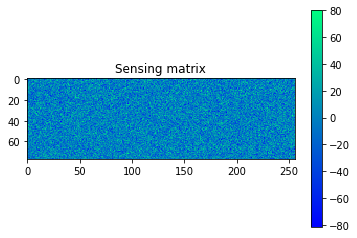

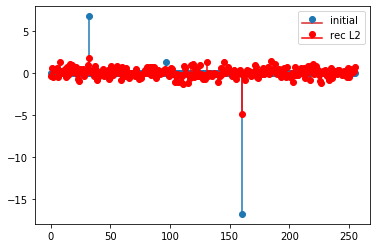

In [25]:
# Sparse signal
n = 256
s = 3

x = np.zeros(n)
x[np.random.permutation(n)[:s]] = np.random.randn(s) * 10

plt.figure()
plt.stem(x);
plt.title('Original signal')

# Measurements
prop = 0.3
m = np.round(prop*n)
A = np.random.randn(int(m),n) * 20.0

plt.figure()
plt.imshow(A, cmap='winter')
plt.title('Sensing matrix')
plt.colorbar()

y = A.dot(x)

# L2 reconstruction - to be coded

x_l2 = A.T.dot(np.linalg.solve(A.dot(A.T), y))

plt.figure()
plt.stem(x, label='initial')
plt.stem(x_l2, linefmt='r-', markerfmt='ro', basefmt='r-', label="rec L2")
plt.legend();

# III. Link between sensing and representation bases
## (just to get some intuition)

In this section, we want to compare the sparse reconstruction (coded in a black box) of various sparse signals.


__ Exercise 7 __


Run the following code and explain what you observe.
Compute the coherence for the first two sensing matrices.

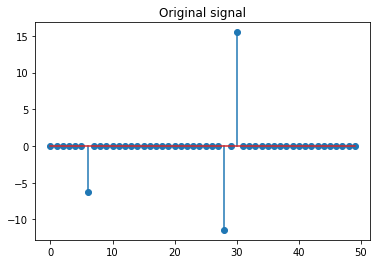

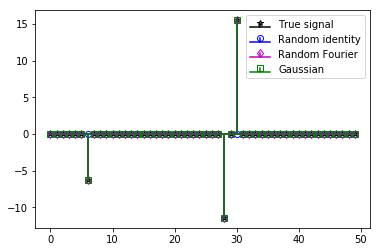

In [26]:
# Sparse signal to be reconstructed
n = 50
s = 3
x = np.zeros(n)
x[np.random.permutation(n)[:s]] = np.random.randn(s) * 20

plt.figure()
plt.stem(x);
plt.title('Original signal')

# 3 different sensing matrices and the associated data
m = int(np.round(0.3*n))  # number of measurements

ind1 = np.random.permutation(n)[:int(m)]
aux = np.eye(n)
A1 = aux[ind1]  # randomly selected atoms of the canonical basis
y1 = A1.dot(x)

ind2 = np.random.permutation(n)[:int(m)]
aux2 = np.fft.fft(np.eye(n))
A2 = aux2[ind2] / np.sqrt(n)  # randomly selected atoms of the Fourier basis
y2 = A2.dot(x)

A3 = np.random.randn(m, n) * 10  # Gaussian matrix
y3 = A3.dot(x)

# Corresponding L1 reconstructions
niter = 100
x1, lun1, err1 = MinL1_DR(y1, A1, niter)
x2, lun2, err2 = MinL1_DR(y2, A2, niter)
x3, lun3, err3 = MinL1_DR(y3, A3, niter)

plt.figure()
markerline, _, _ = plt.stem(x, linefmt='k-', markerfmt='k*', basefmt='k-', label='True signal')
plt.setp(markerline, 'fillstyle', 'none')
markerline, _, _ = plt.stem(x1, linefmt='b-', markerfmt='bo', basefmt='b-', label="Random identity")
plt.setp(markerline, 'fillstyle', 'none')
markerline, _, _ = plt.stem(x2, linefmt='m-', markerfmt='md', basefmt='m-', label="Random Fourier")
plt.setp(markerline, 'fillstyle', 'none')
markerline, _, _ = plt.stem(x3, linefmt='g-', markerfmt='gs', basefmt='g-', label="Gaussian")
plt.setp(markerline, 'fillstyle', 'none')
plt.legend();

$(\star \star \star)$ only for those who want to go further (what's following is totally out of scope of this master course).


Estimate the coherence for a Gaussian matrix $A\in \mathbb{R}^{m\times n}$ which entry are i.i.d. $\mathcal{N}(0,1/n)$. To do so, one can use the (concentration) results of the Boucheron, Lugosi, Massart's book "Concentration inequalities" (Thm 2.3 + Example 2.7 would lead to the result).

__ Exercise 8 __

The setting of Magnetic Resonance Imaging (MRI) is considered in this section.
1. Recall what are the typical sensing and representation bases in the case of MRI.
+  Run the following code.
+  What are the differences between the two sensing matrices used here? 
+  ($\star \star$) In terms of coherence? Deduce some weakness on the present definition of coherence.

Text(0.5,1,'2nd mask: set of selected sampled locations')

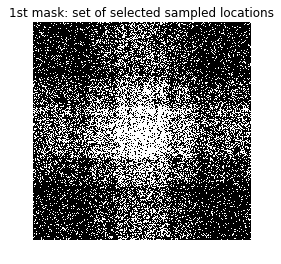

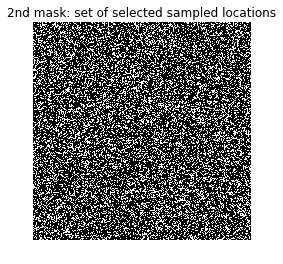

In [27]:
# Comparison in the MRI case
im = load_image("nt_toolbox/data/phantom.bmp")
p = im.shape[0]
m = int(np.round(0.3 * p**2))  # Number of measurements

# Parameters for the wavelets filter
d = 2
level = 3
J = np.log2(p)
Jmin = max(1, J-level)
hparams = ('Daubechies', 10)

# Loading the sampling mask - the sampled frequencies correspond to white dots
mask = loadmat('nt_toolbox/data/mask512.mat')['mask']

plt.figure()
plt.imshow(mask, cmap='gray');
plt.axis('off')
plt.title('1st mask: set of selected sampled locations')

# Another sampling mask
mask_unif = np.zeros((p, p))
ind = np.random.permutation(p**2)[:m]
mask_unif.flat[ind] = 1

plt.figure()
plt.imshow(mask_unif, cmap='gray');
plt.axis('off')
plt.title('2nd mask: set of selected sampled locations')



Text(0.5,1,'L1 reconstruction with the 2nd mask')

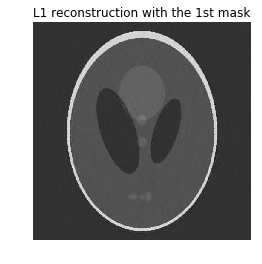

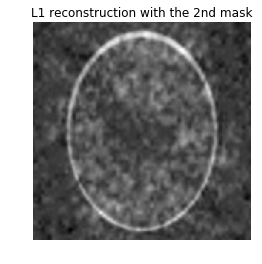

In [28]:
# measurements corresponding to both masks
measurements = np.fft.fftshift(mask) * np.fft.fft2(im) / p
measurements_unif = np.fft.fftshift(mask_unif) * np.fft.fft2(im) / p

# L1-reconstruction 
# Beware : execution time of the order of 1 min
niter = 20
rec, lun, err = MinL1_fw_2d(mask, measurements, level, hparams=hparams, niter=niter)
rec_unif, lun_unif, err_unif = MinL1_fw_2d(mask_unif, measurements, level, hparams=hparams, niter=niter)

# Reconstruction display
h = compute_wavelet_filter(*hparams)
rec_trans = perform_wavortho_transf(rec, Jmin, -1, h)
rec_unif_trans = perform_wavortho_transf(rec_unif, Jmin, -1, h)

plt.figure()
plt.imshow(rec_trans, cmap='gray');
plt.axis('off')
plt.title('L1 reconstruction with the 1st mask')

plt.figure()
plt.imshow(rec_unif_trans, cmap='gray');
plt.axis('off')
plt.title('L1 reconstruction with the 2nd mask')